In [5]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import itertools as it


In [6]:
dst_dir = Path("plots")
dst_dir.mkdir(exist_ok=True, parents=True)

In [7]:
def DIPDI(outputs_A, outputs_B):
    N_AB = torch.norm(outputs_A[0] - outputs_B[0], p=2) * torch.norm(
        outputs_A[1] - outputs_B[1], p=2
    )
    N_AA = torch.norm(outputs_A[0] - outputs_A[1], p=2)
    N_BB = torch.norm(outputs_B[0] - outputs_B[1], p=2)

    return torch.log(N_AB / (N_AA * N_BB + 1e-8))

def MAE(data, test):
    return np.mean(np.abs(data[data["a"] == test]["y"].values - data[data["a"] == test]["y_pred"].values))

In [8]:
output_dir = Path("trained_models/")
shifts = ["male", "female"]
num_folds = 5
younger_proportions = [0.5, 0.6, 0.7, 0.8, 0.9]
results_utk = pd.DataFrame(columns=["Shift", "Younger Proportion", "Fold", "DIPDI", "MAE_Male", "MAE_Female"])

num_groups = 4
list_of_two_groups = list(it.combinations(range(num_groups), 2))
list_of_pairs_of_two_groups = list(it.product(list_of_two_groups, list_of_two_groups))

shift_all = []
younger_prop_all = []
folds_all = []
dipdi_all = []
mae_male_all = []
mae_female_all = []

for shift in shifts:
  for younger_prop in younger_proportions:
    for fold in range(num_folds):
      dipdi_pairs = []
      mae_means_m = []
      mae_means_f = []
      
      i, j = 0, 1
      k, l = 2, 3

      data_male_i = pd.read_csv(output_dir / shift / f"{younger_prop}/fold{fold}_group{i}_male_predictions.csv")
      data_male_j = pd.read_csv(output_dir / shift / f"{younger_prop}/fold{fold}_group{j}_male_predictions.csv")
      data_female_k = pd.read_csv(output_dir / shift / f"{younger_prop}/fold{fold}_group{k}_female_predictions.csv")
      data_female_l = pd.read_csv(output_dir / shift / f"{younger_prop}/fold{fold}_group{l}_female_predictions.csv")
        
      outputs_A = torch.tensor(data_male_i["y_pred"].values), torch.tensor(data_male_j["y_pred"].values)
      outputs_B = torch.tensor(data_female_k["y_pred"].values), torch.tensor(data_female_l["y_pred"].values)

      dipdi = DIPDI(outputs_A, outputs_B)

      mae_A_i_m = MAE(data_male_i, "Male")
      mae_A_j_m = MAE(data_male_j, "Male")
      mae_B_k_m = MAE(data_female_k, "Male")
      mae_B_l_m = MAE(data_female_l, "Male")

      mae_A_i_f = MAE(data_male_i, "Female")
      mae_A_j_f = MAE(data_male_j, "Female")
      mae_B_k_f = MAE(data_female_k, "Female")
      mae_B_l_f = MAE(data_female_l, "Female")

      mae_A_m = (mae_A_i_m + mae_A_j_m) / 2
      mae_B_m = (mae_B_k_m + mae_B_l_m) / 2

      mae_A_f = (mae_A_i_f + mae_A_j_f) / 2
      mae_B_f = (mae_B_k_f + mae_B_l_f) / 2

      mae_diff_m = abs(mae_A_m - mae_B_m)
      mae_diff_f = abs(mae_A_f - mae_B_f)

      shift_all.append(shift)
      younger_prop_all.append(younger_prop)
      folds_all.append(fold)
      mae_male_all.append(mae_diff_m)
      mae_female_all.append(mae_diff_f)
      dipdi_all.append(dipdi.item())

results_utk = pd.DataFrame({"Shift": shift_all, "Younger Proportion": younger_prop_all, "Fold": folds_all, "DIPDI": dipdi_all, "MAE_Male": mae_male_all, "MAE_Female": mae_female_all})

In [9]:
results_utk["Fold"].value_counts()

0    10
1    10
2    10
3    10
4    10
Name: Fold, dtype: int64

Matplotlib is building the font cache; this may take a moment.


Text(0.5, 0.98, 'UTKFace: Shift on Test Data (only Males)')

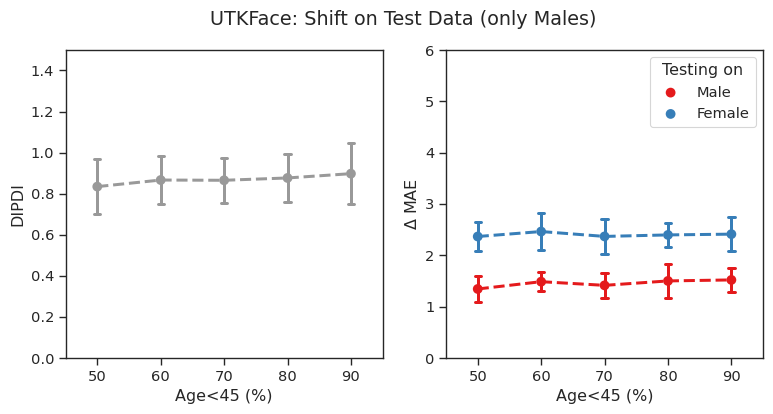

In [10]:
results_male = results_utk[results_utk["Shift"] == "male"]
# colors = list(sns.color_palette("Set2").as_hex())

sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.2)
palette_name = "Set1"
colors = sns.color_palette(palette_name)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

sns.pointplot(data=results_male, ax=ax1, x="Younger Proportion", y="DIPDI", errorbar="sd", color=colors[-1], capsize=.1, linestyles="--")
sns.pointplot(data=results_male, ax=ax2, x="Younger Proportion", y="MAE_Male", errorbar="sd", color=colors[0], label="Male", capsize=.1, linestyles="--")
sns.pointplot(data=results_male, ax=ax2, x="Younger Proportion", y="MAE_Female", errorbar="sd", color=colors[1], label="Female", capsize=.1, linestyles="--")

# ax1.grid(axis="y", alpha=0.5)
# ax2.grid(axis="y", alpha=0.5)

ax1.set_ylim(0.0, 1.5)
ax2.set_ylim(0.0, 6.0)

ax2.legend(title="Testing on", loc="upper right")

ax1.set_ylabel("DIPDI")
ax2.set_ylabel(r"$\Delta$ MAE")

ax1.set_xlabel("Age<45 (%)")
ax2.set_xlabel("Age<45 (%)")

ax1.set_xticklabels(["50", "60", "70", "80", "90"])
ax2.set_xticklabels(["50", "60", "70", "80", "90"])

# sns.despine()
plt.suptitle("UTKFace: Shift on Test Data (only Males)")#, fontsize=11)
# plt.savefig(dst_dir / "dipdi_shift_utk_male.png", dpi=300, bbox_inches="tight")

Text(0.5, 0.98, 'UTKFace: Shift on Test Data (only Females)')

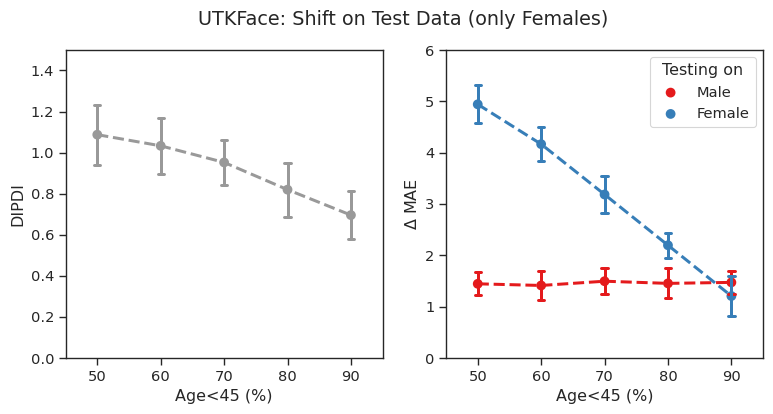

In [11]:
results_female = results_utk[results_utk["Shift"] == "female"]
# colors = list(sns.color_palette("Set2").as_hex())

sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.2)
palette_name = "Set1"
colors = sns.color_palette(palette_name)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

sns.pointplot(data=results_female, ax=ax1, x="Younger Proportion", y="DIPDI", errorbar="sd", color=colors[-1], capsize=.1, linestyles="--")
sns.pointplot(data=results_female, ax=ax2, x="Younger Proportion", y="MAE_Male", errorbar="sd", color=colors[0], label="Male", capsize=.1, linestyles="--")
sns.pointplot(data=results_female, ax=ax2, x="Younger Proportion", y="MAE_Female", errorbar="sd", color=colors[1], label="Female", capsize=.1, linestyles="--")

# ax1.grid(axis="y", alpha=0.5)
# ax2.grid(axis="y", alpha=0.5)

ax1.set_ylim(0.0, 1.5)
ax2.set_ylim(0.0, 6.0)

ax2.legend(title="Testing on", loc="upper right")

ax1.set_ylabel("DIPDI")
ax2.set_ylabel(r"$\Delta$ MAE")

ax1.set_xlabel("Age<45 (%)")
ax2.set_xlabel("Age<45 (%)")

ax1.set_xticklabels(["50", "60", "70", "80", "90"])
ax2.set_xticklabels(["50", "60", "70", "80", "90"])

# sns.despine()
plt.suptitle("UTKFace: Shift on Test Data (only Females)")#, fontsize=11)
# plt.savefig(dst_dir / "dipdi_shift_utk_female.png", dpi=300, bbox_inches="tight")